In [1]:
import os
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from matplotlib.ticker import MultipleLocator


os.chdir('/home/rfpred')
sys.path.append('/home/rfpred')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

print(sys.path)
%pwd

['/home/rfpred/notebooks', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode']


'/home/rfpred'

In [5]:
from funcs.imgproc import get_imgs_designmx, rms_all, feature_df, show_stim, get_rms_contrast, get_rms_contrast_lab, get_contrast_df, get_img_prf
from funcs.rf_tools import get_mask, css_gaussian_cut, make_circle_mask, make_visrois_dict, write_prf_dict
from funcs.utility import print_dict_structure, print_large, get_zscore, hypotheses_plot


In [3]:
n_subjects = len(os.listdir('/home/rfpred/data/natural-scenes-dataset/nsddata/ppdata'))
vismask_dict = make_visrois_dict(vox_count = 'y', bin_check = 'n', n_subjects=n_subjects)
prf_dict = write_prf_dict(binary_masks = vismask_dict)

Subject 1
V1_mask
Non-zero voxels in V1_mask: 7887
V2_mask
Non-zero voxels in V2_mask: 8296
V3_mask
Non-zero voxels in V3_mask: 7022
V4_mask
Non-zero voxels in V4_mask: 3976
Subject 2
V1_mask
Non-zero voxels in V1_mask: 6476
V2_mask
Non-zero voxels in V2_mask: 6376
V3_mask
Non-zero voxels in V3_mask: 6236
V4_mask
Non-zero voxels in V4_mask: 2887
Subject 3
V1_mask
Non-zero voxels in V1_mask: 7358
V2_mask
Non-zero voxels in V2_mask: 6721
V3_mask
Non-zero voxels in V3_mask: 5316
V4_mask
Non-zero voxels in V4_mask: 2486
Subject 4
V1_mask
Non-zero voxels in V1_mask: 5119
V2_mask
Non-zero voxels in V2_mask: 5088
V3_mask
Non-zero voxels in V3_mask: 4669
V4_mask
Non-zero voxels in V4_mask: 2790
Subject 5
V1_mask
Non-zero voxels in V1_mask: 6502
V2_mask
Non-zero voxels in V2_mask: 6309
V3_mask
Non-zero voxels in V3_mask: 5383
V4_mask
Non-zero voxels in V4_mask: 3184
Subject 6
V1_mask
Non-zero voxels in V1_mask: 6479
V2_mask
Non-zero voxels in V2_mask: 6905
V3_mask
Non-zero voxels in V3_mask: 71

In [118]:
testdf = get_contrast_df(100, start_img_no = 0, roi = 'V1', subject = 'subj01', ecc_max = 1, ecc_strict = 'y', prf_proc_dict = prf_dict, binary_masks = vismask_dict, rf_type = 'center', contrast_type = 'rms_lab')

Processing image number: 0 out of 100
Processing image number: 10 out of 100
Processing image number: 20 out of 100
Processing image number: 30 out of 100
Processing image number: 40 out of 100
Processing image number: 50 out of 100
Processing image number: 60 out of 100
Processing image number: 70 out of 100
Processing image number: 80 out of 100
Processing image number: 90 out of 100


This is the sequential version that calculates the rms values per image, not needed anymore.

In [132]:

# Function to calculate rms scores for image independent of design matrix. Faster option, later should be used to fill the
# dictionaries based on the design matrices. 

def rms_all(start, n, ecc_max = 1):
    rms_vec = []
    img_vec = range(start, start + n)
    dim = show_stim(hide = 'y')[0].shape[0]
    x = y = (dim + 1)/2
    radius = ecc_max * (dim / 8.4)
    mask_w_in = css_gaussian_cut(dim, x, y, radius)
    rf_mask_in = make_circle_mask(dim, x, y, radius, fill = 'y', margin_width = 0)
    for i in img_vec:
        ar_in = show_stim(img_no = start + i, hide = 'y')[0]  
        
        rms_vec.append(get_rms_contrast_lab(ar_in, mask_w_in, rf_mask_in, normalise = True, plot = 'n'))
        
    rms_dict = pd.DataFrame({
        'rms': rms_vec
    })
    
    rms_dict.set_index(np.array(img_vec))
    return rms_dict
        
    


Use these codes to collect the rms values for all the images separately, then later on assign them based on the desing matrices. This saves a lot of time. Check the later code for what is useful and what not. The whole get_contrast_df function should probably be adapted in a way, as it is really not efficient anymore. But it definitely has useful components such as the df creation and uhhhh yeah I guess that's it.

In [4]:
from multiprocessing import Pool

def rms_single(args, ecc_max = 1):
    i, start, n = args
    
    dim = show_stim(hide = 'y')[0].shape[0]
    x = y = (dim + 1)/2
    radius = ecc_max * (dim / 8.4)
    mask_w_in = css_gaussian_cut(dim, x, y, radius)
    rf_mask_in = make_circle_mask(dim, x, y, radius, fill = 'y', margin_width = 0)
    
    ar_in = show_stim(img_no = i, hide = 'y')[0]
    
    if i % 1000 == 0:
        print(f"Processing image number: {i} out of {n + start}")
    return get_rms_contrast_lab(ar_in, mask_w_in, rf_mask_in, normalise = True, plot = 'n')

def rms_all(start, n, ecc_max = 1):
    img_vec = list(range(start, start + n))

    # Create a pool of worker processes
    with Pool() as p:
        rms_vec = p.map(rms_single, [(i, start, n) for i in img_vec])

    rms_dict = pd.DataFrame({
        'rms': rms_vec
    })

    rms_dict = rms_dict.set_index(np.array(img_vec))
    return rms_dict

In [8]:
rms_all(72900, 101)

IndexError: Index (73000) out of range for (0-72999)

In [12]:
rms_test = rms_all(start = 72998, n = 2)
rms_test

,rms
72998,28.464819
72999,18.567823


In [8]:
rms_test

,rms
50000,49.052758
50001,24.905137
50002,31.856996
50003,15.854710
50004,22.857796
...,...
69995,16.541329
69996,34.381727
69997,20.663087
69998,39.007011


In [10]:
rms_test.to_pickle('rms_lab_df_20-50k.pkl')
# rms_lab_df_10k.to_pickle('rms_lab_df_10k.pkl')

In [13]:
latest_rms = pd.read_pickle('all_rms_lab_df_72k')
all_rms = pd.DataFrame({'rms': np.append(latest_rms['rms'], rms_test['rms'])})

print(all_rms)
all_rms.to_pickle('all_rms_lab_df')

             rms
0      24.850763
1      66.215949
2      15.592134
3      15.113406
4      32.931833
...          ...
72995  32.597843
72996  19.921272
72997  54.109564
72998  28.464819
72999  18.567823

[73000 rows x 1 columns]


These RMS values have been collected based on the LAB lightness, or luminance values. This is postulated as being the best representative for human visual perception.

Yes and it is very slow. This took more than an hour, and now I've got a version that does the same in 10 min.

In [5]:
rms_lab_df_10k = get_contrast_df(10000, start_img_no = 0, roi = 'V1', subject = 'subj01', ecc_max = 1, ecc_strict = 'y', prf_proc_dict = prf_dict, binary_masks = vismask_dict, rf_type = 'center')
rms_lab_df_10k.to_pickle('rms_lab_df_10k.pkl')

Processing image number: 0 out of 10000
Processing image number: 10 out of 10000
Processing image number: 20 out of 10000
Processing image number: 30 out of 10000
Processing image number: 40 out of 10000
Processing image number: 50 out of 10000
Processing image number: 60 out of 10000
Processing image number: 70 out of 10000
Processing image number: 80 out of 10000
Processing image number: 90 out of 10000
Processing image number: 100 out of 10000
Processing image number: 110 out of 10000
Processing image number: 120 out of 10000
Processing image number: 130 out of 10000
Processing image number: 140 out of 10000
Processing image number: 150 out of 10000
Processing image number: 160 out of 10000
Processing image number: 170 out of 10000
Processing image number: 180 out of 10000
Processing image number: 190 out of 10000
Processing image number: 200 out of 10000
Processing image number: 210 out of 10000
Processing image number: 220 out of 10000
Processing image number: 230 out of 10000
Pro

In [212]:
rms_lab_subj01 = pd.read_pickle('/home/rfpred/rms_lab_df_10k.pkl')
rms_lab_subj01.shape[0]

# Standardize the root mean square values by turning them into z-scores
# rms_lab_z = get_zscore(rms_lab_subj01['rms'], print_ars = 'n')
# rms_lab_subj01['rms'] = rms_lab_z

rms_lab_subj01['image_id'][0]

rms_lab_subj01[000:100]

,rms,image_id,subject,central_radius
0,24.850763,46002,subj01,1
1,66.215949,61882,subj01,1
2,15.592134,828,subj01,1
3,15.113406,67573,subj01,1
4,32.931833,16020,subj01,1
...,...,...,...,...
95,9.153318,50102,subj01,1
96,49.319350,21683,subj01,1
97,30.953718,31968,subj01,1
98,44.166184,25260,subj01,1


#### The following 3 code sections involve the old RMS computations

These are wrong, as the values do not correspond with the image_id, but actually only with the first 30.000 images of the 73.000 dataset. not very useful at all.

In [205]:
all_rms = pd.DataFrame({'rms': np.append(rms_lab_subj01['rms'], rms_test['rms'])})

print(all_rms)
# all_rms.to_pickle('all_rms_lab_df_20k')

             rms
0      24.850763
1      66.215949
2      15.592134
3      15.113406
4      32.931833
...          ...
19995  30.471547
19996  43.315133
19997  28.705528
19998  11.648056
19999  24.322731

[20000 rows x 1 columns]


In [78]:
rms_subj01 = pd.read_pickle('/home/rfpred/rms_df_subj01.pkl')
rms_subj01.shape[0]

30000

In [6]:
# Standardize the root mean square values by turning them into z-scores
rms_z = get_zscore(rms_subj01['rms'], print_ars = 'n')
rms_subj01['rms'] = rms_z

In [79]:
rms_subj01


,rms,image_id,roi,subject
0,23.642583,46002,V1,subj01
1,63.647350,61882,V1,subj01
2,15.106963,828,V1,subj01
3,15.123642,67573,V1,subj01
4,32.203252,16020,V1,subj01
...,...,...,...,...
29995,28.400372,13773,V1,subj01
29996,33.316182,66767,V1,subj01
29997,33.374350,53167,V1,subj01
29998,46.894380,1943,V1,subj01


In [95]:
def get_contrast_df(n_images = None, start_img_no = 0 ,roi = 'V1', subject = 'subj01', ecc_max = 1, ecc_strict = 'y', 
                     prf_proc_dict = None, binary_masks = None, rf_type = 'prf', contrast_type = 'rms_lab'):
    
    designmx = get_imgs_designmx()
    
    if n_images == 'all':
        n_images = len(designmx['subj01'])
    
    indices, rms_list, image_id_list= [], [], []
      
    img_vec = designmx[subject][start_img_no : n_images + start_img_no]  
    
    # for img_no in range(start_img_no, n_images + start_img_no):
    for n_img, img_id in enumerate(img_vec):
        ar_in = show_stim(img_no = img_id, hide = 'y')[0]
        
        if rf_type == 'prf':
            # Acquire mask based on subject, roi, outline. Type is cut_gaussian by default, based on NSD paper
            rf_info = get_mask(dim = 425, subject = subject, binary_masks = binary_masks, 
                                            prf_proc_dict = prf_proc_dict, type='cut_gaussian', roi=roi,
                                            plot = 'n', excl_reason = 'n', sigma_min=0, sigma_max = 4.2, 
                                            ecc_max = ecc_max, ecc_strict = ecc_strict)
            
            # Get the location and radius of the patch
            x, y = rf_info['x'].astype('int'), rf_info['y'].astype('int')
            radius = rf_info['pix_radius'].astype('int')
            mask_w_in = rf_info['mask']
            
            # Create boolean mask of exact same size as weighted pRF patch
            rf_mask_in = make_circle_mask(425, x, y, radius, fill = 'y', margin_width = 0)
            
        elif rf_type == 'center':
            dim = ar_in.shape[0]
            x = y = (dim + 1)/2
            radius = ecc_max * (dim / 8.4)
            mask_w_in = css_gaussian_cut(dim, x, y, radius)
            rf_mask_in = make_circle_mask(dim, x, y, radius, fill = 'y', margin_width = 0)
            
        # Get root mean square contrast of image and add to list
        indices.append(n_img)
        
        if contrast_type == 'rms_lab':
            rms_list.append(get_rms_contrast_lab(ar_in, mask_w_in, rf_mask_in, normalise = True, plot = 'n'))
        elif contrast_type == 'rms':
            rms_list.append(get_rms_contrast(ar_in, mask_w_in, rf_mask_in, normalise = True, plot = 'n'))
            
        # rms_list.append(get_rms_contrast(ar_in, mask_w_in, rf_mask_in, normalise = True))
        image_id_list.append(designmx[subject][n_img])
        # roi_list.append(roi)
        # subject_list.append(subject)
        if n_img % 10 == 0:
            print(f"Processing image number: {n_img} out of {n_images + start_img_no}")

    contrast_df = pd.DataFrame({
        'rms': rms_list,
        'image_id': image_id_list
        # 'roi': roi_list,
        # 'subject': subject_list
    })
    
    # Remove this roi thing, or well, only when rf_type = 'center'
    # contrast_df.insert(2, 'roi', [roi] * contrast_df.shape[0])
    contrast_df.insert(2, 'subject', [subject] * contrast_df.shape[0])
    contrast_df.insert(3, 'central_radius', [ecc_max] * contrast_df.shape[0])
    
    contrast_df = contrast_df.set_index(np.array(indices))
    
    return contrast_df

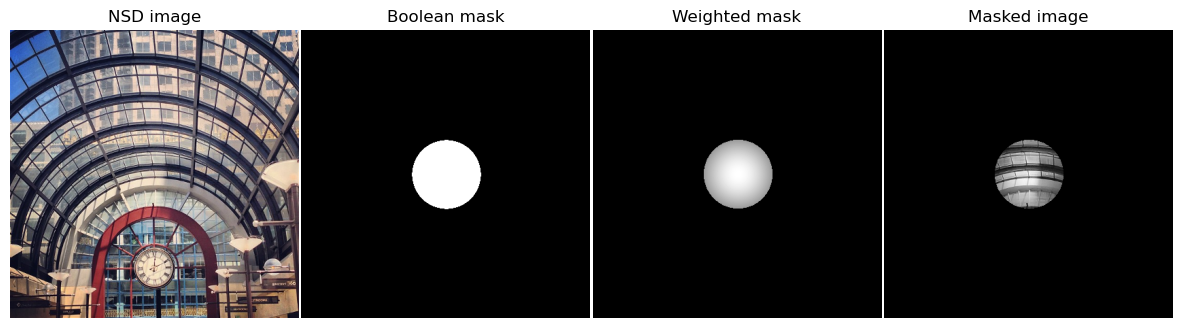

In [4]:
# Choose image from the natural scenes dataset
img_no = 29

img = show_stim(img_no = img_no, hide = 'y')[0]

# Create the mask and acquire relevant parameters.
info = get_mask(dim = 425, subject = 'subj01', binary_masks = vismask_dict, 
                                        prf_proc_dict = prf_dict, type='outline', roi='V2',
                                        plot = 'n', excl_reason = 'n', sigma_min=0, sigma_max = 1.2, 
                                        ecc_max = 1, fill_outline = 'y', grid = 'y')

weighted_mask = css_gaussian_cut(425, 213, 213, (425/8.4))

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
plt.subplots_adjust(wspace=0.01)

# Plot the first image in the first subplot
axs[0].imshow(img)
axs[0].set_title('NSD image')
axs[0].axis('off') 
# Plot the second image in the second subplot
axs[2].imshow(weighted_mask, cmap = 'gist_gray')
axs[2].set_title('Weighted mask')
axs[2].axis('off') 
axs[1].imshow(info['mask'], cmap = 'gist_gray')
axs[1].set_title('Boolean mask')
axs[1].axis('off') 

# Plot the weighted masked image in the fourth subplot
weighted_masked_image = np.multiply(np.mean(img, axis = -1), weighted_mask)
axs[3].imshow(weighted_masked_image, cmap = 'gist_gray')
axs[3].set_title('Masked image')
axs[3].axis('off') 
plt.show()


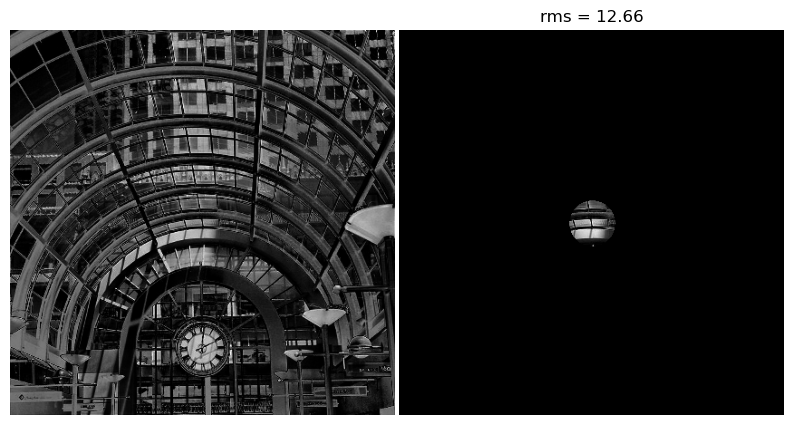

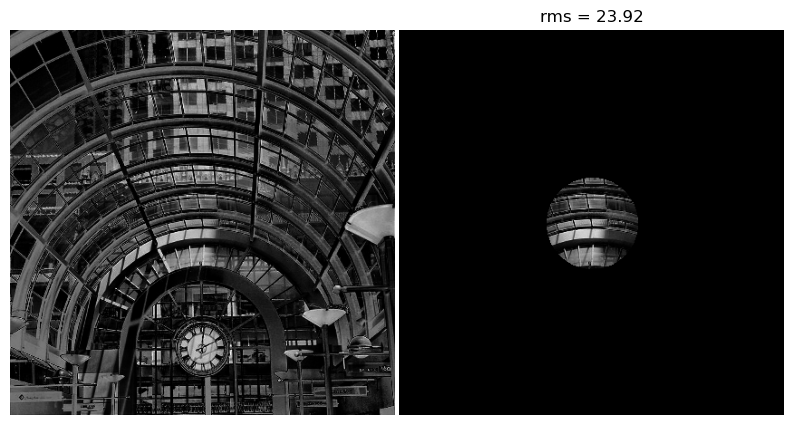

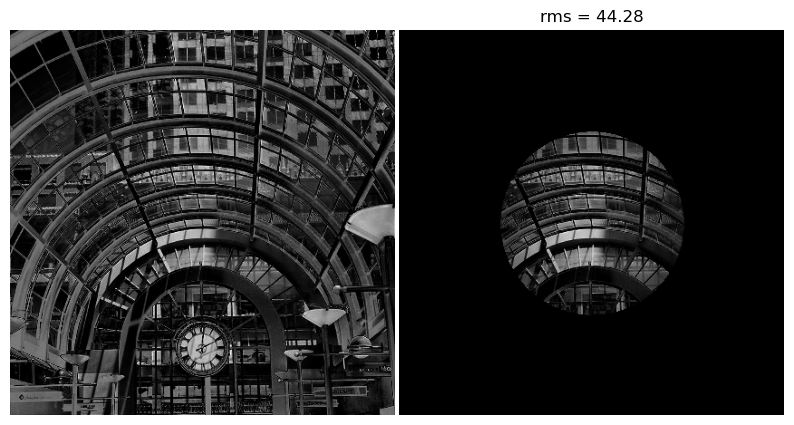

In [5]:
# This is when using the L parameter of the LAB colour space, which is the luminance channel. Best to use.
# Check to see whether my function actually exclusively calculates the RMS of the patch. It does.

tiny = get_rms_contrast_lab(img, css_gaussian_cut(425, 213, 213, (425/16.8)), info['mask'], normalise = True, plot = 'y')

small = get_rms_contrast_lab(img, css_gaussian_cut(425, 213, 213, (425/8.4)), info['mask'], normalise = True, plot = 'y')

big = get_rms_contrast_lab(img, css_gaussian_cut(425, 213, 213, (425/4.2)), info['mask'], normalise = True, plot = 'y')

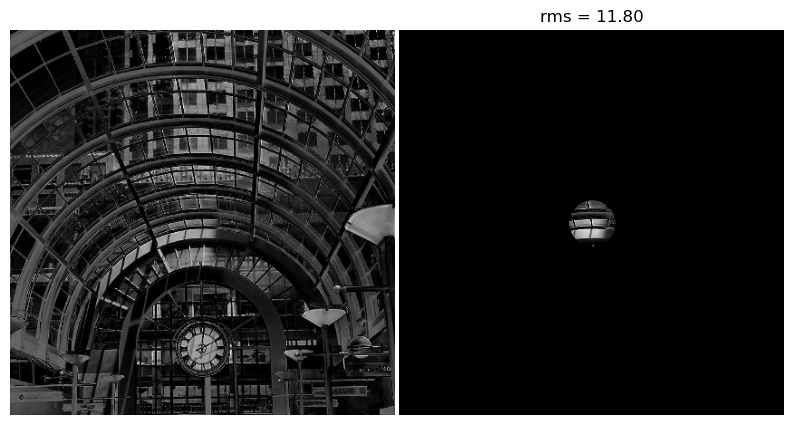

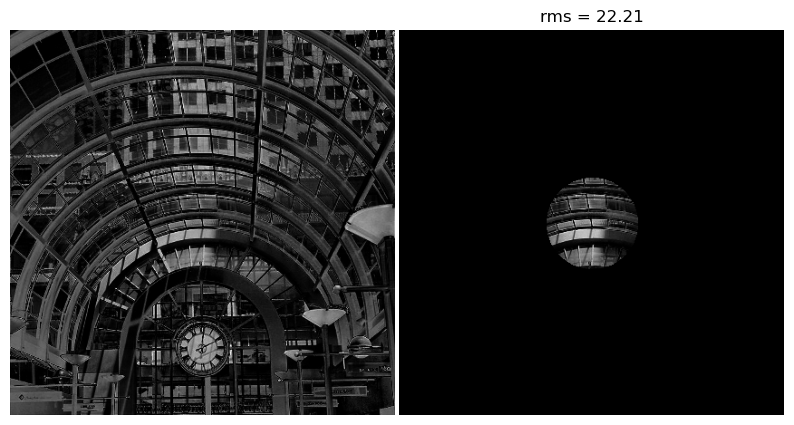

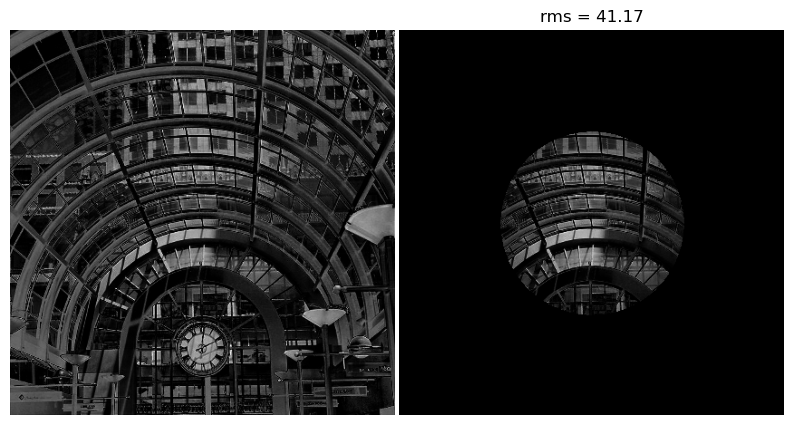

In [6]:
# This is the original RMS function, which does not use the lightness parameter. The differences are minute.
# Check to see whether my function actually exclusively calculates the RMS of the patch. It does.

tiny = get_rms_contrast(img, css_gaussian_cut(425, 213, 213, (425/16.8)), info['mask'], normalise = True, plot = 'y')

small = get_rms_contrast(img, css_gaussian_cut(425, 213, 213, (425/8.4)), info['mask'], normalise = True, plot = 'y')

big = get_rms_contrast(img, css_gaussian_cut(425, 213, 213, (425/4.2)), info['mask'], normalise = True, plot = 'y')